In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import shap

In [ ]:
# 1) 데이터 로딩, 불필요한 행과 열 제거
dataset = pd.read_excel("dataset-uci 2.xls")

dataset = dataset.drop(23)
dataset = dataset.drop('Obesity (%)', axis=1)

In [ ]:
# 2) X, y 분리
y = dataset.iloc[:, 0].values
X = dataset.iloc[:, 1:].values
feature_names = dataset.columns[1:]

In [ ]:
# 3) train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=0,
    stratify=y
)

In [ ]:
# 4) 표준화
scaler      = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

In [ ]:
# 5) 모델 정의, 학습

# 5-1) CatBoost
cb = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    eval_metric='Accuracy',
    random_seed=0,
    verbose=False
)
cb.fit(X_train_std, y_train, eval_set=(X_test_std, y_test))

In [ ]:
# 5-2) LR
lr = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='liblinear',
    random_state=0
)
lr.fit(X_train_std, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [ ]:
# 5-3) LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_std, y_train)

LinearDiscriminantAnalysis()

In [ ]:
# 5-4) QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_std, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


QuadraticDiscriminantAnalysis()

In [ ]:
# 6) 성능 평가
models = {
    'CatBoost' : cb,
    'Logistic' : lr,
    'LDA'      : lda,
    'QDA'      : qda
}

print("모델별 Train/Test 정확도")
for name, model in models.items():
    train_acc = accuracy_score(y_train, model.predict(X_train_std))
    test_acc  = accuracy_score(y_test,  model.predict(X_test_std))
    print(f"{name:9s} → train: {train_acc:.3f}  test: {test_acc:.3f}")

모델별 Train/Test 정확도
CatBoost  → train: 1.000  test: 0.740
Logistic  → train: 0.923  test: 0.760
LDA       → train: 0.860  test: 0.740
QDA       → train: 0.815  test: 0.750


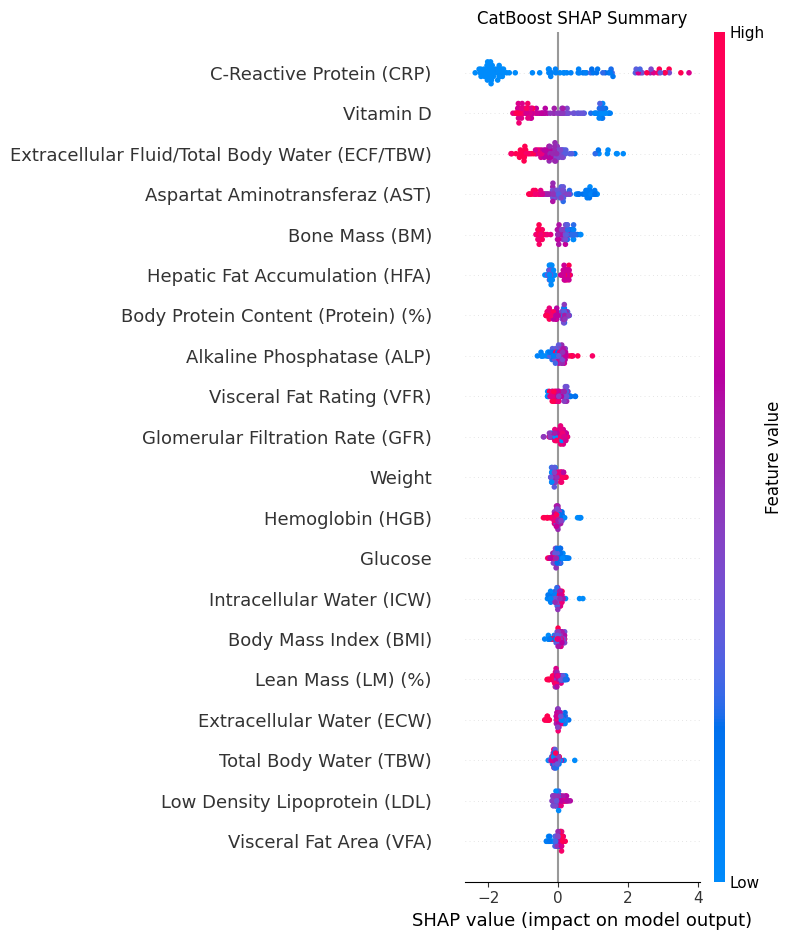

In [ ]:
# 7) 모델 해석 지표, 시각화

# 7-1) CatBoost SHAP summary plot
explainer     = shap.TreeExplainer(cb)
shap_values   = explainer.shap_values(X_test_std)
shap.summary_plot(shap_values, X_test_std,
                  feature_names=feature_names,
                  show=False)
plt.title("CatBoost SHAP Summary")
plt.tight_layout()
plt.show()

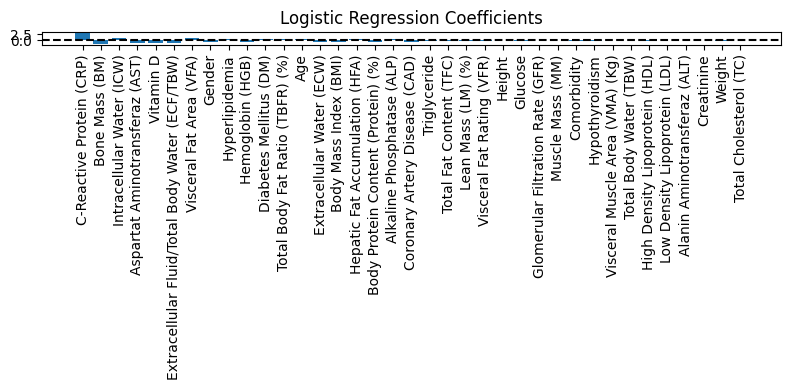

In [ ]:
# 7-2) Logistic 회귀 계수 시각화
coef = lr.coef_[0]
idx  = np.argsort(np.abs(coef))[::-1]
plt.figure(figsize=(8,4))
plt.bar(feature_names[idx], coef[idx])
plt.xticks(rotation=90)
plt.axhline(0, color='black', linestyle='--')
plt.title("Logistic Regression Coefficients")
plt.tight_layout()
plt.show()


[LDA] 클래스별 평균 벡터:
  class 0: [-0.039 -0.143  0.084  0.101 -0.001 -0.152 -0.094  0.108 -0.071 -0.148
  0.098  0.172  0.009  0.196 -0.237  0.241  0.072 -0.028  0.225  0.066
 -0.193 -0.16   0.085 -0.108  0.002 -0.045 -0.016 -0.176  0.071  0.209
  0.122 -0.179  0.126 -0.009 -0.388  0.203  0.397]
  class 1: [ 0.039  0.145 -0.085 -0.103  0.002  0.155  0.095 -0.11   0.072  0.151
 -0.099 -0.175 -0.009 -0.199  0.241 -0.245 -0.073  0.029 -0.229 -0.068
  0.197  0.163 -0.087  0.11  -0.002  0.046  0.017  0.179 -0.072 -0.213
 -0.124  0.183 -0.128  0.009  0.395 -0.207 -0.405]
LDA scalings: [[ 0.341]
 [-0.828]
 [-0.055]
 [-0.195]
 [ 0.065]
 [ 0.304]
 [ 0.388]
 [-0.008]
 [-0.519]
 [-0.44 ]
 [ 0.558]
 [-1.47 ]
 [ 0.83 ]
 [ 0.11 ]
 [ 1.921]
 [ 0.343]
 [-0.157]
 [-0.63 ]
 [-0.658]
 [ 1.492]
 [-0.371]
 [ 0.188]
 [-0.007]
 [ 0.318]
 [-0.083]
 [ 0.223]
 [-0.134]
 [-0.004]
 [-0.344]
 [-0.274]
 [ 0.1  ]
 [ 0.208]
 [-0.096]
 [-0.015]
 [ 0.459]
 [-0.306]
 [-0.603]]


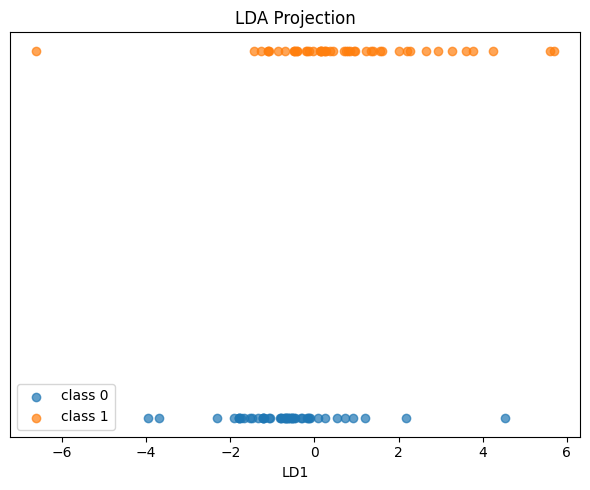

In [ ]:
# 7-3) LDA: 클래스별 평균, 투영 시각화
print("\n[LDA] 클래스별 평균 벡터:")
for i, mean in enumerate(lda.means_):
    print(f"  class {i}: {np.round(mean,3)}")
print("LDA scalings:", np.round(lda.scalings_,3))

# LDA 변환 결과
X_lda = lda.transform(X_test_std)
n_comp = X_lda.shape[1]

plt.figure(figsize=(6,5))

if n_comp >= 2:
    # 2차원 투영 (LD1 vs LD2)
    X2 = X_lda[:, :2]
    for cls in np.unique(y_test):
        xi, yi = X2[y_test == cls, 0], X2[y_test == cls, 1]
        plt.scatter(xi, yi, label=f"class {cls}", alpha=0.7)
    plt.xlabel("LD1")
    plt.ylabel("LD2")

else:
    # 1차원 투영 → y축에 작은 오프셋을 주어 시각화
    X1 = X_lda[:, 0]
    classes = np.unique(y_test)
    offsets = np.linspace(-0.1, 0.1, len(classes))
    for cls, off in zip(classes, offsets):
        xi = X1[y_test == cls]
        yi = np.zeros_like(xi) + off
        plt.scatter(xi, yi, label=f"class {cls}", alpha=0.7)
    plt.xlabel("LD1")
    plt.yticks([])  # y축 눈금 제거

plt.title("LDA Projection")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 7-4) QDA: 클래스별 평균, 공분산
print("\n[QDA] 클래스별 평균 벡터:")
for i, mean in enumerate(qda.means_):
    print(f"  class {i}: {np.round(mean,3)}")

qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train_std, y_train)

print("\n[QDA] 클래스별 공분산 행렬:")
for i, cov in enumerate(qda.covariance_):
    print(f"  class {i} covariance:\n{np.round(cov,3)}\n")


[QDA] 클래스별 평균 벡터:
  class 0: [-0.039 -0.143  0.084  0.101 -0.001 -0.152 -0.094  0.108 -0.071 -0.148
  0.098  0.172  0.009  0.196 -0.237  0.241  0.072 -0.028  0.225  0.066
 -0.193 -0.16   0.085 -0.108  0.002 -0.045 -0.016 -0.176  0.071  0.209
  0.122 -0.179  0.126 -0.009 -0.388  0.203  0.397]
  class 1: [ 0.039  0.145 -0.085 -0.103  0.002  0.155  0.095 -0.11   0.072  0.151
 -0.099 -0.175 -0.009 -0.199  0.241 -0.245 -0.073  0.029 -0.229 -0.068
  0.197  0.163 -0.087  0.11  -0.002  0.046  0.017  0.179 -0.072 -0.213
 -0.124  0.183 -0.128  0.009  0.395 -0.207 -0.405]

[QDA] 클래스별 공분산 행렬:
  class 0 covariance:
[[ 1.17   0.008  0.498 ...  0.024 -0.076 -0.029]
 [ 0.008  0.973 -0.108 ...  0.031 -0.677  0.034]
 [ 0.498 -0.108  1.247 ...  0.013  0.074  0.083]
 ...
 [ 0.024  0.031  0.013 ...  0.026 -0.027  0.019]
 [-0.076 -0.677  0.074 ... -0.027  0.832 -0.073]
 [-0.029  0.034  0.083 ...  0.019 -0.073  0.863]]

  class 1 covariance:
[[ 0.842  0.185  0.23  ...  0.064 -0.149  0.056]
 [ 0.185  1.004  

/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
